In [77]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the training dataset
train_df = pd.read_csv("train.csv")

# Load the test dataset
test_df = pd.read_csv("test.csv")
# Overview of the dataset
print(train_df.head())  # Display the first few rows of the dataset




  Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier

In [71]:
# Summary statistics
print(train_df.describe())  # Display summary statistics of numeric columns

       Item_Weight  Item_Visibility     Item_MRP  Outlet_Establishment_Year  \
count  7060.000000      8523.000000  8523.000000                8523.000000   
mean     12.857645         0.066132   140.992782                1997.831867   
std       4.643456         0.051598    62.275067                   8.371760   
min       4.555000         0.000000    31.290000                1985.000000   
25%       8.773750         0.026989    93.826500                1987.000000   
50%      12.600000         0.053931   143.012800                1999.000000   
75%      16.850000         0.094585   185.643700                2004.000000   
max      21.350000         0.328391   266.888400                2009.000000   

       Item_Outlet_Sales  
count        8523.000000  
mean         2181.288914  
std          1706.499616  
min            33.290000  
25%           834.247400  
50%          1794.331000  
75%          3101.296400  
max         13086.964800  


In [18]:
# Check data types and missing values
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None


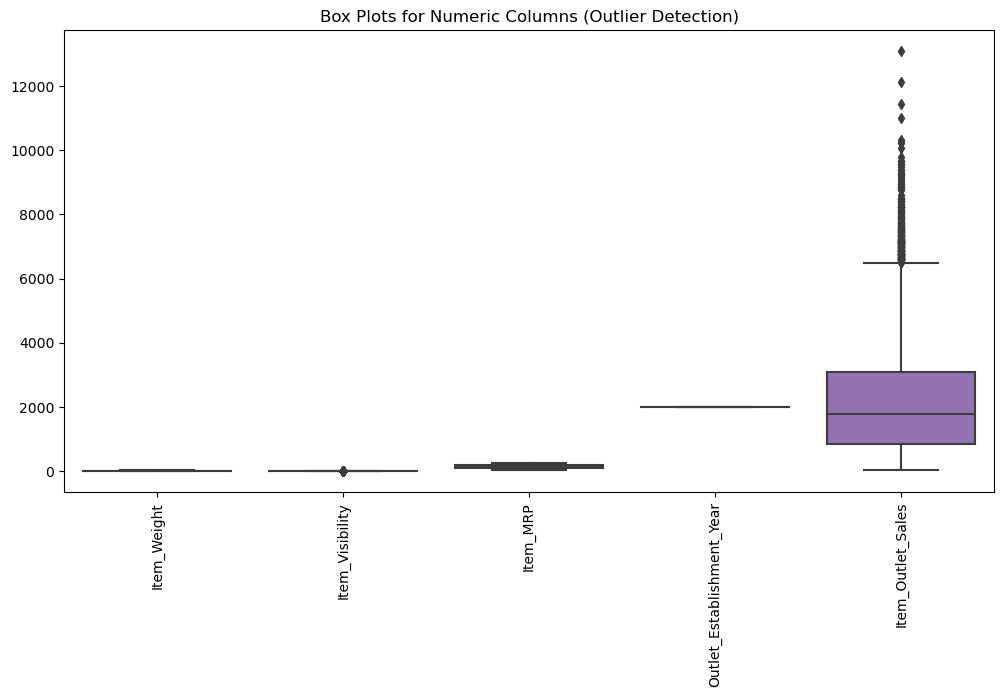

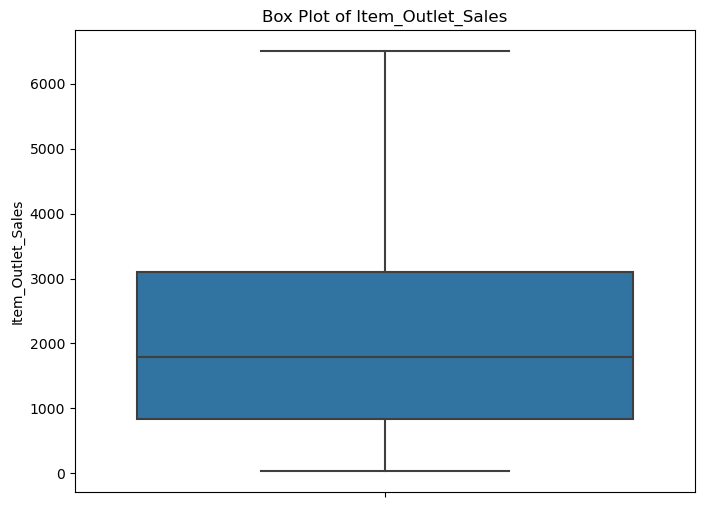

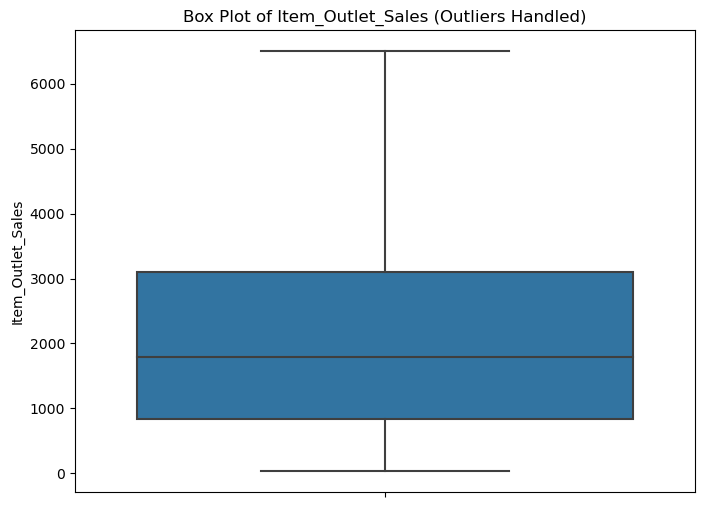

In [74]:

# Create box plots for numeric columns where you suspect outliers
numeric_columns = train_df.select_dtypes(include=['number'])

# Create a box plot for each numeric column
plt.figure(figsize=(12, 6))
sns.boxplot(data=numeric_columns)
plt.xticks(rotation=90)
plt.title("Box Plots for Numeric Columns (Outlier Detection)")
plt.show()


# Visualize the distribution of 'Item_Outlet_Sales' using a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='Item_Outlet_Sales')
plt.title("Box Plot of Item_Outlet_Sales")
plt.show()

# Calculate the Interquartile Range (IQR)
Q1 = train_df['Item_Outlet_Sales'].quantile(0.25)
Q3 = train_df['Item_Outlet_Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and handle outliers by capping them at the upper bound
train_df['Item_Outlet_Sales'] = np.where(train_df['Item_Outlet_Sales'] > upper_bound, upper_bound, train_df['Item_Outlet_Sales'])

# After handling outliers, you can visualize the distribution again
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, y='Item_Outlet_Sales')
plt.title("Box Plot of Item_Outlet_Sales (Outliers Handled)")
plt.show()

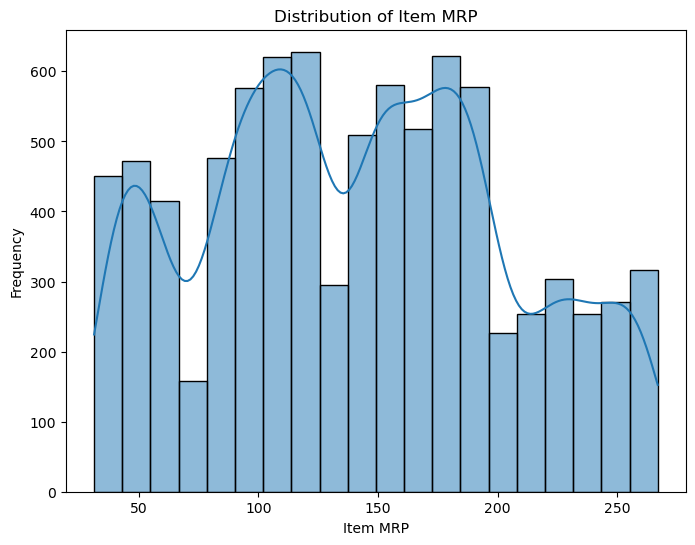

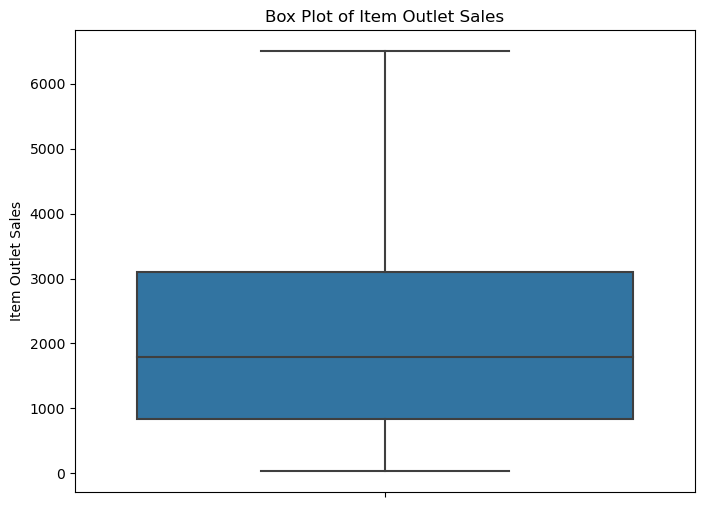

C:\Users\VIVEK PATEL\AppData\Local\Temp\ipykernel_7888\123919779.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_df.corr()


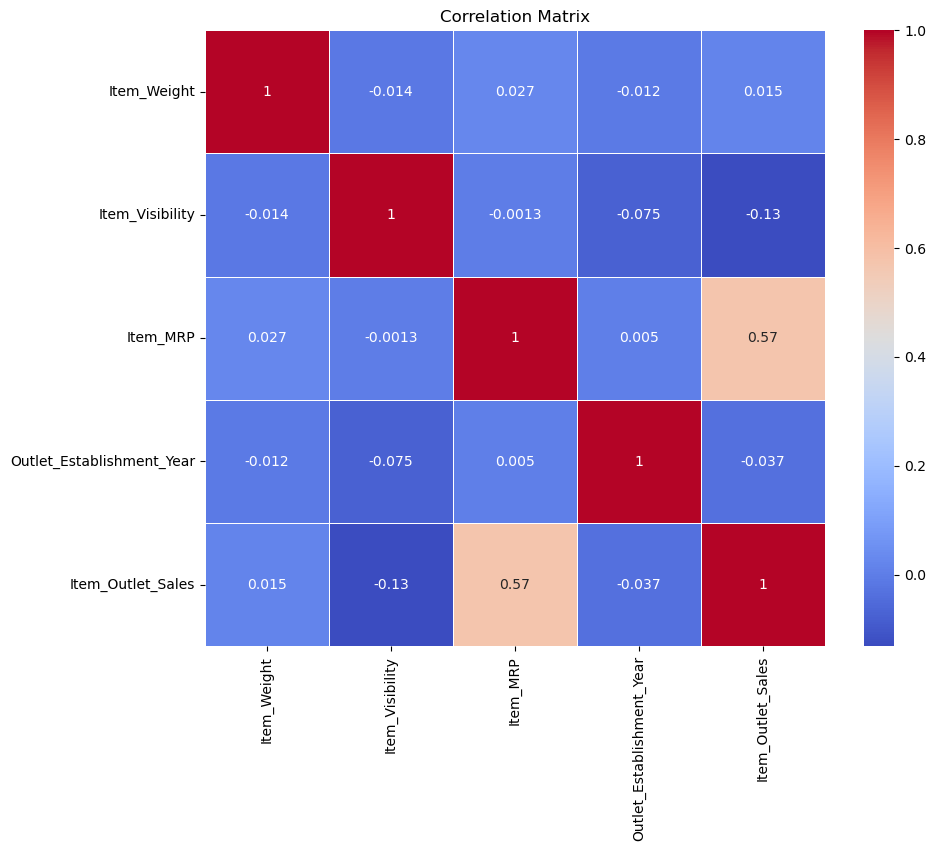

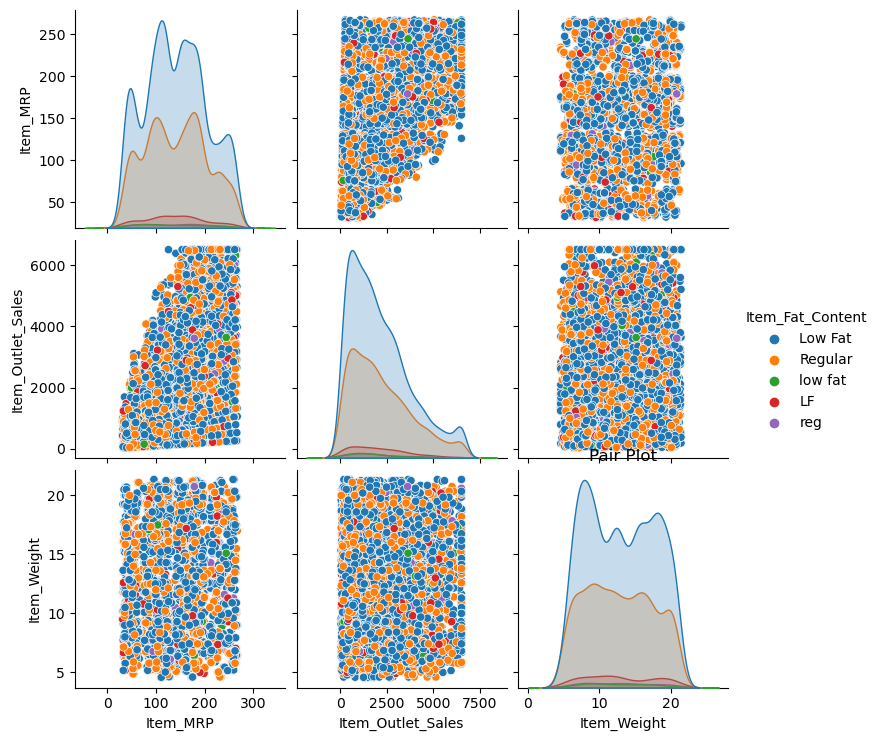

In [75]:
# Visualizing distributions and relationships
# Example: Histogram of 'Item_MRP'
plt.figure(figsize=(8, 6))
sns.histplot(train_df['Item_MRP'], bins=20, kde=True)
plt.title("Distribution of Item MRP")
plt.xlabel("Item MRP")
plt.ylabel("Frequency")
plt.show()

# Example: Box plot of 'Item_Outlet_Sales'
plt.figure(figsize=(8, 6))
sns.boxplot(data=train_df, y='Item_Outlet_Sales')
plt.title("Box Plot of Item Outlet Sales")
plt.ylabel("Item Outlet Sales")
plt.show()

# Correlation matrix
correlation_matrix = train_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Pair plot
sns.pairplot(train_df, vars=['Item_MRP', 'Item_Outlet_Sales', 'Item_Weight'], hue='Item_Fat_Content')
plt.title("Pair Plot")
plt.show()

In [69]:


# Drop the 'Item_Identifier' column as it's not a useful feature for prediction
train_df = train_df.drop("Item_Identifier", axis=1)
test_df = test_df.drop("Item_Identifier", axis=1)

# Perform one-hot encoding for categorical columns present in both datasets
common_categorical_cols = set(train_df.columns) & set(test_df.columns)
for col in common_categorical_cols:
    if train_df[col].dtype == 'object':  # Check if the column is categorical
        train_df = pd.get_dummies(train_df, columns=[col])
        test_df = pd.get_dummies(test_df, columns=[col])

# Separate features and target variable in the training dataset
X_train = train_df.drop("Item_Outlet_Sales", axis=1)
y_train = train_df["Item_Outlet_Sales"]

# Separate features in the test dataset
X_test = test_df  # Assuming the test dataset has the same features as the training dataset

# Impute missing values using the mean (you can choose a different strategy)
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


# Create and train a Gradient Boosting Regressor (GBR) model
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a GBR model with the best hyperparameters
best_gbr = GradientBoostingRegressor(**best_params, random_state=42)

# Train the best model on the entire training set
best_gbr.fit(X_train, y_train)

# Scale the features in the training and test datasets (choose one scaling method)
scaler = StandardScaler()  # or RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Make final predictions on the test dataset using the trained model
final_predictions = best_gbr.predict(X_test_scaled)
print(final_predictions)
# 'final_predictions' now contains the predicted values for the test dataset


[700.52158869 763.29102615  69.22508249 ... 691.77300336 706.05427387
 691.77300336]
